# Tools & Imports

In [ ]:
import numpy as np
import pandas as pd
import os
import json
import zipfile
import tensorflow as tf
from tqdm import tqdm
import pickle

# NLP Imorts
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional

# Model Creation Imports
from tensorflow.keras.models import Sequential, Model

# Computer Vision Imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import DenseNet201

# Model Learning & Losses Imports
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Warning & Visualization Imports
import warnings
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style('dark')
warnings.filterwarnings('ignore')

# Download and Load Dataset

In [ ]:
import kagglehub
path = kagglehub.dataset_download("adityajn105/flickr30k")

In [ ]:
path

'/kaggle/input/flickr30k'

In [ ]:
image_path = path + "/Images"
data = pd.read_csv(path + '/captions.txt')
data.head()

,image,caption
0,1000092795.jpg,Two young guys with shaggy hair look at their...
1,1000092795.jpg,"Two young , White males are outside near many..."
2,1000092795.jpg,Two men in green shirts are standing in a yard .
3,1000092795.jpg,A man in a blue shirt standing in a garden .
4,1000092795.jpg,Two friends enjoy time spent together .


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158915 entries, 0 to 158914
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   image    158915 non-null  object
 1   caption  158914 non-null  object
dtypes: object(2)
memory usage: 2.4+ MB


## Filling the missing data

In [ ]:
import matplotlib.image as mpimg

missing_img = data[data['caption'].isna()]['image'].values[0]

img_path = f"{path}/Images/{missing_img}"
img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis("off")
plt.show()

In [ ]:
data.loc[data['caption'].isna(), 'caption'] = "A dog running on the grass with mouth open"

In [ ]:
data.info()

# Sample Data Showcase

In [ ]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.

    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"{path}/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

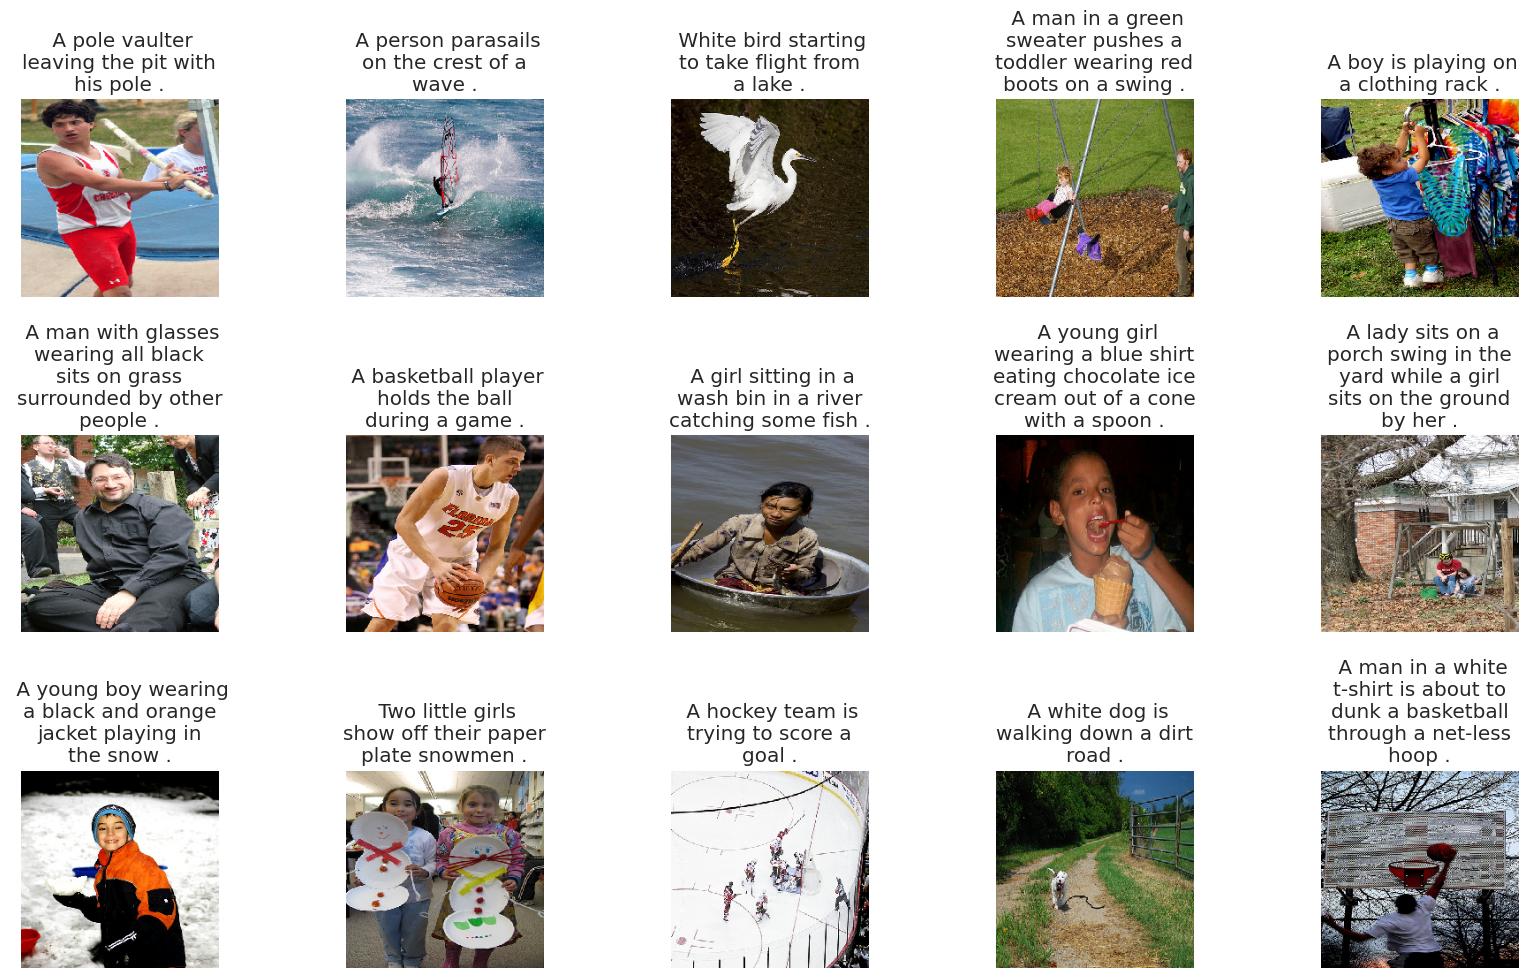

In [ ]:
display_images(data.sample(15))

# Text Preprocessing

In [ ]:
def text_preprocessing(data):
    data['caption'] = data['caption'].str.lower()
    data['caption'] = data['caption'].str.replace('[^a-z]', ' ', regex=True)                           # remove everything except letters
    data['caption'] = data['caption'].str.replace('\s+', ' ', regex=True).str.strip()                  # remove extra whitespaces
    data['caption'] = data['caption'].apply(lambda x: " ".join([w for w in x.split() if len(w) > 1]))  # remove single letter words
    data['caption'] = data['caption'].apply(lambda x: f"startseq {x} endseq")
    return data

data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq',
 'startseq two young white males are outside near many bushes endseq',
 'startseq two men in green shirts are standing in yard endseq',
 'startseq man in blue shirt standing in garden endseq',
 'startseq two friends enjoy time spent together endseq',
 'startseq several men in hard hats are operating giant pulley system endseq',
 'startseq workers look down from up above on piece of equipment endseq',
 'startseq two men working on machine wearing hard hats endseq',
 'startseq four men on top of tall structure endseq',
 'startseq three men on large rig endseq']

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
max_length = max([len(caption.split()) for caption in captions])
tokenizer.texts_to_sequences([captions[1]])[0]

# Train Test Split

In [ ]:
images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85 * nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(drop=True,inplace=True)
test.reset_index(drop=True,inplace=True)

# Extracting Image Features

In [ ]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}

for image in tqdm(data['image'].unique().tolist()):
  img = load_img(os.path.join(image_path, image), target_size=(img_size, img_size))
  img = img_to_array(img)
  img = img/255.
  img = np.expand_dims(img, axis=0)
  feature = fe.predict(img, verbose=0)
  features[image] = feature

In [ ]:
# Save Image feature Embeddings
image_features = {k: v.tolist() for k, v in features.items()}
with open("/content/drive/MyDrive/Image-Caption-Generator/image_features.json", "w") as f:
    json.dump(image_features, f)

In [ ]:
# Load Image features Embeddings
with open("/content/drive/MyDrive/Image-Caption-Generator/image_features.json", "r") as f:
    features = json.load(f)

features = {k: np.array(v) for k, v in features.items()}

In [ ]:
# Save the Image feature extractor model and Tokenizer
with open("/content/drive/MyDrive/Image-Caption-Generator/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

fe.save("/content/drive/MyDrive/Image-Caption-Generator/feature_extractor.keras")

In [ ]:
list(features.values())[0].size

# Data Generator

In [ ]:
class CustomDataGenerator(Sequence):

    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features,shuffle=True):

        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self,index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self,batch):

        X1, X2, y = list(), list(), list()

        images = batch[self.X_col].tolist()

        for image in images:
            feature = self.features[image][0]

            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)

        return X1, X2, y


train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [ ]:
train_generator[0]

# One-to-Many LSTM Model

## Model Architecture

In [ ]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)

x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

In [ ]:
caption_model.summary()

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(caption_model,
           show_shapes=True,
           show_layer_names=True,
           to_file="/content//drive/MyDrive/Image-Caption-Generator/model_architecture.png")

## Callbacks

In [ ]:
model_name = "/content/drive/MyDrive/Image-Caption-Generator/Image_caption_generator_model.keras"
checkpoint = ModelCheckpoint(
    model_name,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

## Training the Model

In [ ]:
history = caption_model.fit(
        train_generator,
        epochs=20,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

## Loss Curves

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Caption Generation Utility Functions

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import pickle

model_path = "/content/drive/MyDrive/Image-Caption-Generator/Image_caption_generator_model.keras"
tokenizer_path = "/content/drive/MyDrive/Image-Caption-Generator/tokenizer.pkl"
feature_extractor_path = "/content/drive/MyDrive/Image-Caption-Generator/feature_extractor.keras"


def generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path, max_length=34, img_size=224):
    # Load the trained models and tokenizer
    caption_model = load_model(model_path)
    feature_extractor = load_model(feature_extractor_path)

    with open(tokenizer_path, "rb") as f:
        tokenizer = pickle.load(f)

    # Preprocess the image
    img = load_img(image_path, target_size=(img_size, img_size))
    img = img_to_array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    image_features = feature_extractor.predict(img, verbose=0)

    # Generate the caption
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([image_features, sequence], verbose=0)
        yhat_index = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat_index, None)
        if word is None:
            break
        in_text += " " + word
        if word == "endseq":
            break
    caption = in_text.replace("startseq", "").replace("endseq", "").strip()

    # Display the image with the generated caption
    img = load_img(image_path, target_size=(img_size, img_size))
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption, fontsize=16, color='blue')
    plt.show()

In [ ]:
image_path = f"{path}/Images/1457762320_7fe121b285.jpg"
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)